In [1]:
!pip install ultralytics kagglehub opencv-python-headless matplotlib seaborn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.8 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import shutil
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import cv2
import numpy as np
from ultralytics import YOLO
import kagglehub

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

print("✓ Setup complete!")


✓ Setup complete!


In [4]:
# Download dataset using Kaggle API
print("Downloading dataset...")
path = kagglehub.dataset_download("anulayakhare/crackathon-data")
print(f"Path to dataset files: {path}")

# Create working directory structure
base_dir = Path("/content/road_damage")
base_dir.mkdir(exist_ok=True)

# Explore the actual dataset structure
dataset_path = Path(path)
print(f"\nExploring dataset structure at: {dataset_path}")
print("\nDirectory contents:")
for item in sorted(dataset_path.rglob("*"))[:20]:  # Show first 20 items
    if item.is_file():
        print(f"  FILE: {item.relative_to(dataset_path)}")
    elif item.is_dir():
        print(f"  DIR:  {item.relative_to(dataset_path)}/")

# Try to find the actual structure
def find_images_and_labels(base_path):
    """Find all image and label directories"""
    image_dirs = []
    label_dirs = []

    for path in base_path.rglob("*"):
        if path.is_dir():
            files = list(path.glob("*"))
            if files and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in files):
                image_dirs.append(path)
            elif files and any(f.suffix == '.txt' for f in files):
                # Check if it's a labels directory (not just any txt files)
                sample_file = next((f for f in files if f.suffix == '.txt'), None)
                if sample_file:
                    with open(sample_file, 'r') as f:
                        first_line = f.readline().strip()
                        # Check if it looks like YOLO format
                        if first_line and len(first_line.split()) >= 5:
                            label_dirs.append(path)

    return image_dirs, label_dirs

print("\n\nSearching for image and label directories...")
image_dirs, label_dirs = find_images_and_labels(dataset_path)

print(f"\nFound {len(image_dirs)} image directories:")
for d in image_dirs:
    num_images = len(list(d.glob("*.jpg")) + list(d.glob("*.png")))
    print(f"  - {d.relative_to(dataset_path)}: {num_images} images")

print(f"\nFound {len(label_dirs)} label directories:")
for d in label_dirs:
    num_labels = len(list(d.glob("*.txt")))
    print(f"  - {d.relative_to(dataset_path)}: {num_labels} labels")

# Set up paths based on discovered structure
# The dataset is in randomized_dataset subdirectory
dataset_root = dataset_path / "randomized_dataset"

train_images_path = dataset_root / "train" / "images"
train_labels_path = dataset_root / "train" / "labels"
val_images_path = dataset_root / "val" / "images"
val_labels_path = dataset_root / "val" / "labels"
test_images_path = dataset_root / "test" / "images"

print(f"\n✓ Identified dataset structure:")
print(f"  - Train images: {train_images_path} - {'EXISTS' if train_images_path.exists() else 'NOT FOUND'}")
print(f"  - Train labels: {train_labels_path} - {'EXISTS' if train_labels_path.exists() else 'NOT FOUND'}")
print(f"  - Val images: {val_images_path} - {'EXISTS' if val_images_path.exists() else 'NOT FOUND'}")
print(f"  - Val labels: {val_labels_path} - {'EXISTS' if val_labels_path.exists() else 'NOT FOUND'}")
print(f"  - Test images: {test_images_path} - {'EXISTS' if test_images_path.exists() else 'NOT FOUND'}")

# Verify paths exist
if not train_images_path.exists():
    raise FileNotFoundError(f"Could not find training images at {train_images_path}")
if not test_images_path.exists():
    raise FileNotFoundError(f"Could not find test images at {test_images_path}")

# Note: Validation labels might not exist, which is okay
if not val_labels_path.exists():
    print("\n⚠️  Warning: Validation labels not found. You may need to create them or adjust validation strategy.")


Using Colab cache for faster access to the 'crackathon-data' dataset.
Path to dataset files: /kaggle/input/crackathon-data

Exploring dataset structure at: /kaggle/input/crackathon-data

Directory contents:
  DIR:  randomized_dataset/
  DIR:  randomized_dataset/test/
  DIR:  randomized_dataset/test/images/
  FILE: randomized_dataset/test/images/000004.jpg
  FILE: randomized_dataset/test/images/000019.jpg
  FILE: randomized_dataset/test/images/000030.jpg
  FILE: randomized_dataset/test/images/000031.jpg
  FILE: randomized_dataset/test/images/000036.jpg
  FILE: randomized_dataset/test/images/000041.jpg
  FILE: randomized_dataset/test/images/000045.jpg
  FILE: randomized_dataset/test/images/000055.jpg
  FILE: randomized_dataset/test/images/000056.jpg
  FILE: randomized_dataset/test/images/000057.jpg
  FILE: randomized_dataset/test/images/000079.jpg
  FILE: randomized_dataset/test/images/000087.jpg
  FILE: randomized_dataset/test/images/000094.jpg
  FILE: randomized_dataset/test/images/000

In [5]:
# Create data.yaml for YOLO training
# Use absolute paths to avoid any confusion
data_yaml = {
    'path': str(dataset_root),  # Base path: /kaggle/input/crackathon-data/randomized_dataset
    'train': str(train_images_path),  # Absolute path to train images
    'val': str(val_images_path) if val_images_path.exists() else str(train_images_path),  # Use train if val doesn't exist
    'test': str(test_images_path),  # Absolute path to test images
    'nc': 5,  # number of classes
    'names': {
        0: 'Longitudinal Crack',
        1: 'Transverse Crack',
        2: 'Alligator Crack',
        3: 'Other Corruption',
        4: 'Pothole'
    }
}

yaml_path = base_dir / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("\n✓ Created data.yaml configuration")
print(f"\nYAML Configuration:")
print(f"  path: {data_yaml['path']}")
print(f"  train: {data_yaml['train']}")
print(f"  val: {data_yaml['val']}")
print(f"  test: {data_yaml['test']}")

# Verify the YAML file was created correctly
print("\nVerifying paths in YAML:")
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
    for key in ['train', 'val', 'test']:
        path_to_check = Path(yaml_content[key])
        exists = path_to_check.exists() if path_to_check.is_absolute() else (Path(yaml_content['path']) / yaml_content[key]).exists()
        print(f"  {key}: {yaml_content[key]} - {'✓ EXISTS' if exists else '✗ NOT FOUND'}")



✓ Created data.yaml configuration

YAML Configuration:
  path: /kaggle/input/crackathon-data/randomized_dataset
  train: /kaggle/input/crackathon-data/randomized_dataset/train/images
  val: /kaggle/input/crackathon-data/randomized_dataset/val/images
  test: /kaggle/input/crackathon-data/randomized_dataset/test/images

Verifying paths in YAML:
  train: /kaggle/input/crackathon-data/randomized_dataset/train/images - ✓ EXISTS
  val: /kaggle/input/crackathon-data/randomized_dataset/val/images - ✓ EXISTS
  test: /kaggle/input/crackathon-data/randomized_dataset/test/images - ✓ EXISTS


In [6]:
def count_images_and_labels(images_path, labels_path=None):
    """Count images and labels in a directory"""
    image_files = list(images_path.glob("*.jpg")) + list(images_path.glob("*.png"))
    num_images = len(image_files)

    if labels_path and labels_path.exists():
        label_files = list(labels_path.glob("*.txt"))
        num_labels = len(label_files)
        return num_images, num_labels
    return num_images, 0

# Count dataset statistics
train_img, train_lbl = count_images_and_labels(train_images_path, train_labels_path)
val_img, val_lbl = count_images_and_labels(val_images_path, val_labels_path)
test_img, _ = count_images_and_labels(test_images_path)

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Training Set:   {train_img:,} images, {train_lbl:,} label files")
print(f"Validation Set: {val_img:,} images, {val_lbl:,} label files")
print(f"Test Set:       {test_img:,} images")
print("="*60)


DATASET STATISTICS
Training Set:   26,385 images, 26,385 label files
Validation Set: 6,000 images, 6,000 label files
Test Set:       6,000 images



CLASS DISTRIBUTION (Training Set):
------------------------------------------------------------
0: Longitudinal Crack   - 17,807 instances
1: Transverse Crack     - 8,133 instances
2: Alligator Crack      - 7,224 instances
3: Other Corruption     - 7,281 instances
4: Pothole              - 4,450 instances
------------------------------------------------------------


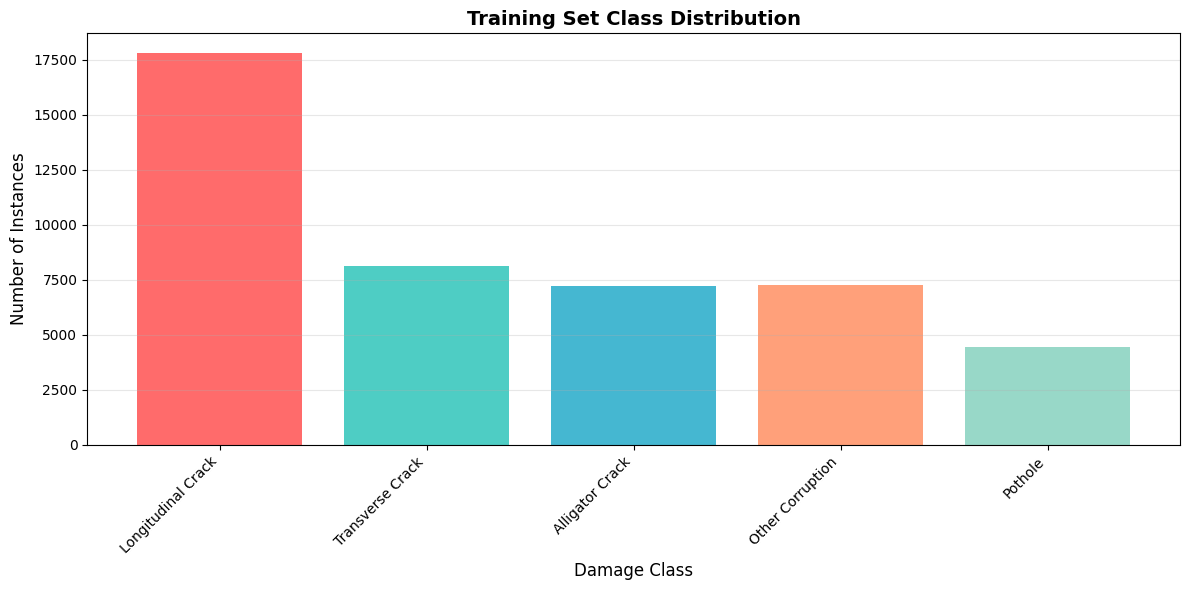

In [7]:
# Analyze class distribution
def analyze_class_distribution(labels_path):
    """Analyze the distribution of classes in the dataset"""
    class_counts = {i: 0 for i in range(5)}

    for label_file in labels_path.glob("*.txt"):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

    return class_counts

# Analyze training set
train_class_dist = analyze_class_distribution(train_labels_path)

print("\nCLASS DISTRIBUTION (Training Set):")
print("-" * 60)
class_names = ['Longitudinal Crack', 'Transverse Crack', 'Alligator Crack',
               'Other Corruption', 'Pothole']
for class_id, count in train_class_dist.items():
    print(f"{class_id}: {class_names[class_id]:<20} - {count:,} instances")
print("-" * 60)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(range(5), [train_class_dist[i] for i in range(5)],
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])
plt.xlabel('Damage Class', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(5), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [8]:
def visualize_samples(images_path, labels_path, num_samples=4):
    """Visualize sample images with bounding boxes"""
    image_files = list(images_path.glob("*.jpg"))[:num_samples]

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()

    colors = {
        0: (255, 0, 0),      # Red - Longitudinal
        1: (0, 255, 0),      # Green - Transverse
        2: (0, 0, 255),      # Blue - Alligator
        3: (255, 255, 0),    # Yellow - Other
        4: (255, 0, 255)     # Magenta - Pothole
    }

    for idx, img_path in enumerate(image_files):
        # Read image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read corresponding label
        label_file = labels_path / f"{img_path.stem}.txt"

        if label_file.exists():
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])

                        # Convert YOLO format to pixel coordinates
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)

                        # Draw bounding box
                        cv2.rectangle(img, (x1, y1), (x2, y2), colors[class_id], 2)
                        cv2.putText(img, class_names[class_id], (x1, y1-10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Sample {idx+1}: {img_path.name}", fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing training samples with annotations...")
visualize_samples(train_images_path, train_labels_path, num_samples=4)


Visualizing training samples with annotations...


In [9]:
print("\n" + "="*60)
print("STARTING MODEL TRAINING")
print("="*60)

# Initialize YOLOv8 model
# Options: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium),
#          yolov8l.pt (large), yolov8x.pt (xlarge)
model = YOLO('yolov8m.pt')  # Using medium model for balance of speed and accuracy

# Training hyperparameters
training_args = {
    'data': str(yaml_path),
    'epochs': 10,              # Increase for better performance
    'imgsz': 640,              # Image size
    'batch': 16,               # Adjust based on GPU memory
    'device': 0,               # Use GPU
    'workers': 8,              # Number of workers for data loading
    'patience': 10,            # Early stopping patience
    'save': True,              # Save checkpoints
    'project': str(base_dir),
    'name': 'road_damage_model',
    'exist_ok': True,

    # Augmentation parameters
    'hsv_h': 0.015,           # HSV-Hue augmentation
    'hsv_s': 0.7,             # HSV-Saturation augmentation
    'hsv_v': 0.4,             # HSV-Value augmentation
    'degrees': 10.0,          # Image rotation (+/- deg)
    'translate': 0.1,         # Image translation (+/- fraction)
    'scale': 0.5,             # Image scale (+/- gain)
    'shear': 0.0,             # Image shear (+/- deg)
    'perspective': 0.0,       # Image perspective (+/- fraction)
    'flipud': 0.0,            # Image flip up-down (probability)
    'fliplr': 0.5,            # Image flip left-right (probability)
    'mosaic': 1.0,            # Mosaic augmentation (probability)
    'mixup': 0.1,             # MixUp augmentation (probability)

    # Optimization parameters
    'optimizer': 'auto',      # Optimizer (auto, SGD, Adam, AdamW)
    'lr0': 0.01,              # Initial learning rate
    'lrf': 0.01,              # Final learning rate (lr0 * lrf)
    'momentum': 0.937,        # SGD momentum/Adam beta1
    'weight_decay': 0.0005,   # Optimizer weight decay
    'warmup_epochs': 3.0,     # Warmup epochs
    'warmup_momentum': 0.8,   # Warmup initial momentum
    'warmup_bias_lr': 0.1,    # Warmup initial bias lr
    'box': 7.5,               # Box loss gain
    'cls': 0.5,               # Class loss gain
    'dfl': 1.5,               # DFL loss gain

    # Advanced options
    'val': True,              # Validate/test during training
    'plots': True,            # Save plots during training
    'save_period': -1,        # Save checkpoint every x epochs (disabled with -1)
}

# Train the model
print("\nTraining configuration:")
for key, value in training_args.items():
    print(f"  {key}: {value}")

print("\nStarting training... This may take a while.")
print("Monitor the training progress below:\n")

results = model.train(**training_args)

print("\n✓ Training complete!")


STARTING MODEL TRAINING

Training configuration:
  data: /content/road_damage/data.yaml
  epochs: 10
  imgsz: 640
  batch: 16
  device: 0
  workers: 8
  patience: 10
  save: True
  project: /content/road_damage
  name: road_damage_model
  exist_ok: True
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
  degrees: 10.0
  translate: 0.1
  scale: 0.5
  shear: 0.0
  perspective: 0.0
  flipud: 0.0
  fliplr: 0.5
  mosaic: 1.0
  mixup: 0.1
  optimizer: auto
  lr0: 0.01
  lrf: 0.01
  momentum: 0.937
  weight_decay: 0.0005
  warmup_epochs: 3.0
  warmup_momentum: 0.8
  warmup_bias_lr: 0.1
  box: 7.5
  cls: 0.5
  dfl: 1.5
  val: True
  plots: True
  save_period: -1

Starting training... This may take a while.
Monitor the training progress below:

Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, c


VALIDATING MODEL
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 410.0±570.8 MB/s, size: 247.6 KB)
val: Scanning /kaggle/input/crackathon-data/randomized_dataset/val/labels... 6000 images, 1792 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6000/6000 276.5it/s 21.7s
WARNING ⚠️ val: Cache directory /kaggle/input/crackathon-data/randomized_dataset/val is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 375/375 2.2it/s 2:51
                   all       6000      10443      0.554      0.495        0.5      0.236
    Longitudinal Crack       2171       4093      0.534      0.498      0.478      0.237
      Transverse Crack       1209       1830      0.546       0.41      0.426      0.176
       Alligator Crack       1353       1698      0.596


Confusion Matrix:


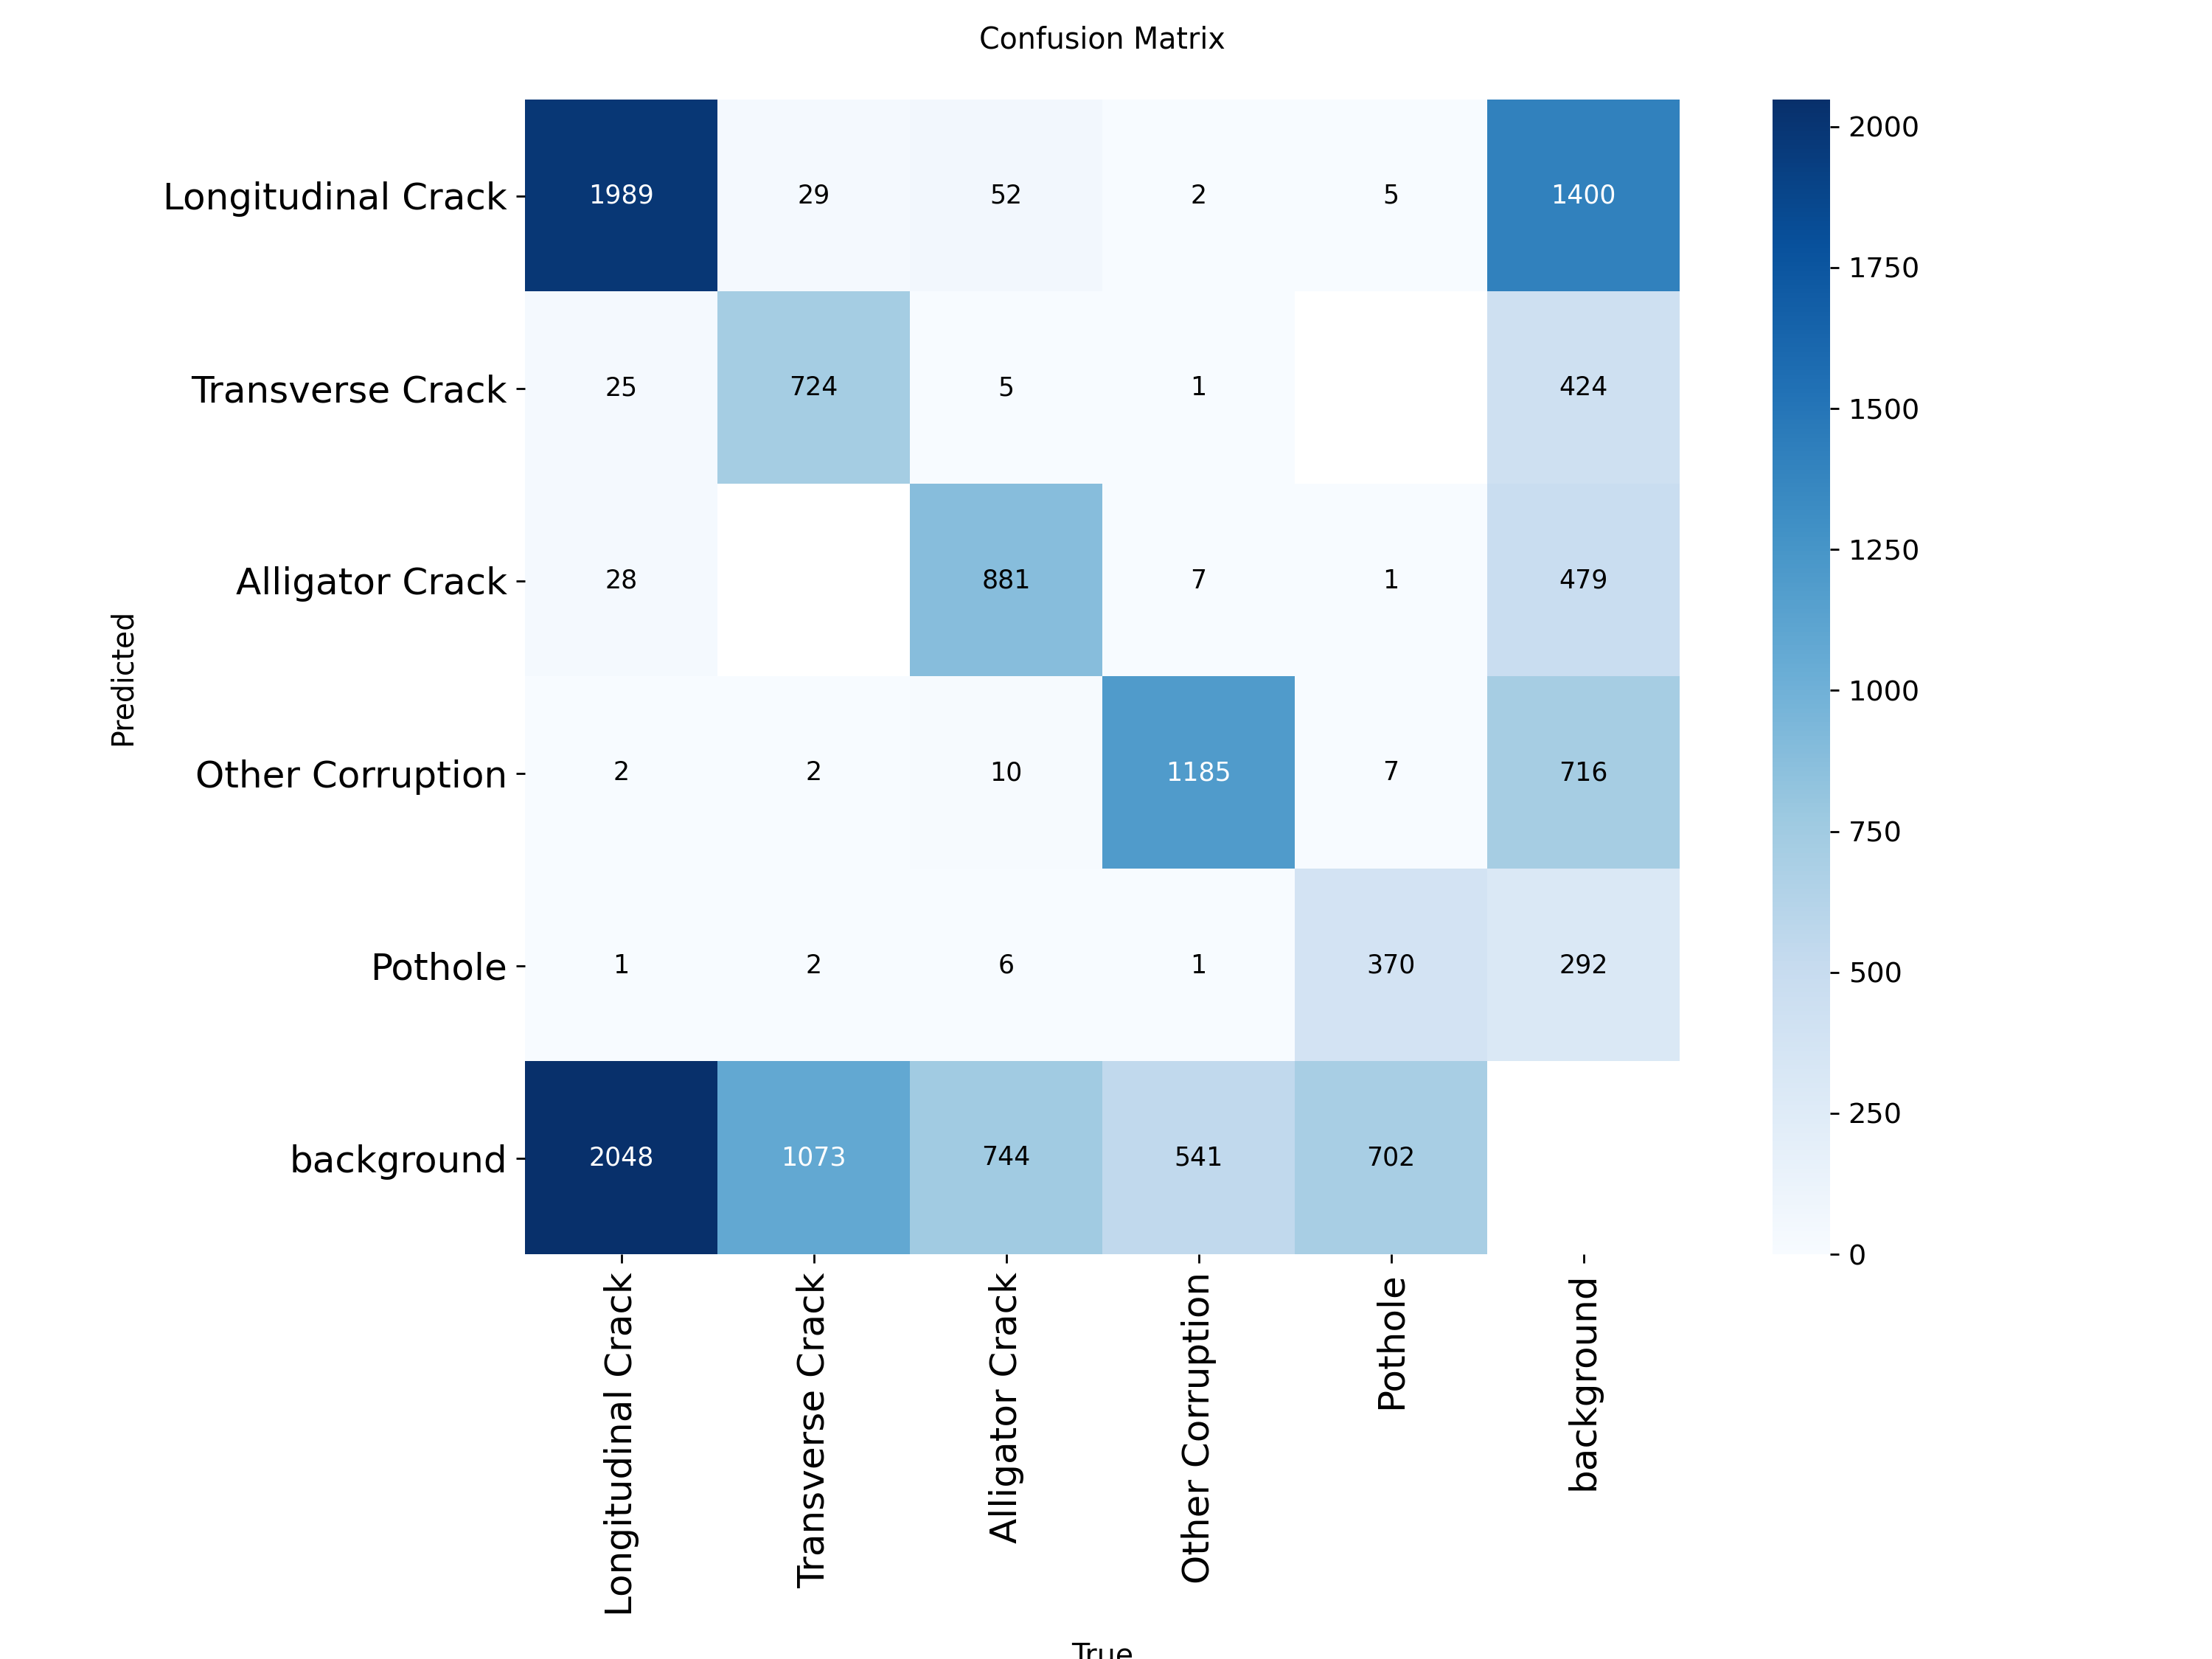

In [10]:
print("\n" + "="*60)
print("VALIDATING MODEL")
print("="*60)

# Validate on validation set
val_results = model.val(data=str(yaml_path))

print("\nValidation Metrics:")
print(f"  mAP@0.5:    {val_results.box.map50:.4f}")
print(f"  mAP@0.5-0.95: {val_results.box.map:.4f}")
print(f"  Precision:  {val_results.box.mp:.4f}")
print(f"  Recall:     {val_results.box.mr:.4f}")

# Display training results
results_dir = base_dir / "road_damage_model"
if (results_dir / "results.png").exists():
    print("\nTraining Results:")
    display(Image(filename=str(results_dir / "results.png")))

if (results_dir / "confusion_matrix.png").exists():
    print("\nConfusion Matrix:")
    display(Image(filename=str(results_dir / "confusion_matrix.png")))

In [ ]:
print("\n" + "="*60)
print("GENERATING TEST SET PREDICTIONS")
print("="*60)

# Create predictions directory
predictions_dir = base_dir / "predictions"
predictions_dir.mkdir(exist_ok=True)

# Get best model weights
best_model_path = results_dir / "weights" / "best.pt"
model = YOLO(str(best_model_path))

print(f"\nLoaded best model from: {best_model_path}")
print(f"Predictions will be saved to: {predictions_dir}")

# Get all test images
test_images = sorted(list(test_images_path.glob("*.jpg")) + list(test_images_path.glob("*.png")))
print(f"\nFound {len(test_images)} test images")

# Generate predictions
print("\nGenerating predictions...")
for i, img_path in enumerate(test_images):
    # Run inference
    results = model.predict(
        source=str(img_path),
        conf=0.25,  # Confidence threshold
        iou=0.45,   # IoU threshold for NMS
        verbose=False
    )

    # Create prediction file
    pred_file = predictions_dir / f"{img_path.stem}.txt"

    with open(pred_file, 'w') as f:
        # Extract predictions
        boxes = results[0].boxes

        if len(boxes) > 0:
            for box in boxes:
                # Get box coordinates in xyxy format
                xyxy = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())

                # Convert to YOLO format (x_center, y_center, width, height)
                img_height, img_width = results[0].orig_shape
                x_center = ((xyxy[0] + xyxy[2]) / 2) / img_width
                y_center = ((xyxy[1] + xyxy[3]) / 2) / img_height
                width = (xyxy[2] - xyxy[0]) / img_width
                height = (xyxy[3] - xyxy[1]) / img_height

                # Write prediction in required format
                f.write(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} {conf:.6f}\n")

    if (i + 1) % 100 == 0:
        print(f"  Processed {i+1}/{len(test_images)} images")

print(f"\n✓ Generated {len(test_images)} prediction files")

In [12]:
print("\n" + "="*60)
print("CREATING SUBMISSION FILE")
print("="*60)

# Create submission zip
submission_zip = base_dir / "submission.zip"
shutil.make_archive(
    str(base_dir / "submission"),
    'zip',
    predictions_dir
)

print(f"\n✓ Created submission file: {submission_zip}")
print(f"  Size: {submission_zip.stat().st_size / (1024*1024):.2f} MB")


CREATING SUBMISSION FILE

✓ Created submission file: /content/road_damage/submission.zip
  Size: 0.76 MB


In [ ]:
print("\n" + "="*60)
print("VISUALIZING TEST PREDICTIONS")
print("="*60)

def visualize_predictions(num_samples=4):
    """Visualize predictions on test images"""
    test_images_sample = sorted(list(test_images_path.glob("*.jpg")))[:num_samples]

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()

    colors = {
        0: (255, 0, 0),      # Red - Longitudinal
        1: (0, 255, 0),      # Green - Transverse
        2: (0, 0, 255),      # Blue - Alligator
        3: (255, 255, 0),    # Yellow - Other
        4: (255, 0, 255)     # Magenta - Pothole
    }

    for idx, img_path in enumerate(test_images_sample):
        # Read image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read prediction
        pred_file = predictions_dir / f"{img_path.stem}.txt"

        if pred_file.exists():
            with open(pred_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 6:
                        class_id = int(parts[0])
                        x_center, y_center, width, height, conf = map(float, parts[1:6])

                        # Convert to pixel coordinates
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)

                        # Draw bounding box
                        cv2.rectangle(img, (x1, y1), (x2, y2), colors[class_id], 2)
                        label = f"{class_names[class_id]} {conf:.2f}"
                        cv2.putText(img, label, (x1, y1-10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Test Image {idx+1}: {img_path.name}", fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(num_samples=4)


In [14]:
from google.colab import files

# Download submission.zip
files.download('/content/road_damage/submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>